<a href="https://colab.research.google.com/github/zaidalyafeai/AttentioNN/blob/master/Attention_in_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some libs to fix Arabic text not showing correctly

In [1]:
!pip install --upgrade arabic-reshaper
!pip install python-bidi

Get the dataset and unzip it 

In [2]:
!wget http://www.manythings.org/anki/ara-eng.zip
!unzip ara-eng.zip

--2019-09-23 14:44:44--  http://www.manythings.org/anki/ara-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270779 (264K) [application/zip]
Saving to: ‘ara-eng.zip’

ara-eng.zip         100%[===================>] 264.43K   424KB/s    in 0.6s    

2019-09-23 14:44:46 (424 KB/s) - ‘ara-eng.zip’ saved [270779/270779]

Archive:  ara-eng.zip
  inflating: _about.txt              
  inflating: ara.txt                 


## Introduction
Traditional nmt models that use [seq2seq](https://arxiv.org/abs/1409.3215) architectures suffer from a bottleneck problem. Only, the final hidden state is used for the deocder to guess the translation. This results in two problems. First, the decoder doesn't utilize the different hidden states that are created by the individual inputs in the encoder. Second, the decoder is not able to guess which parts of the encoder hidden state to focus on at each step of translation. This creates a problem especially when translating long sequences with many words encoded as one hidden state. In order to resolve both problems we use attention-based nmt. These special seq2seq models try to resolve both problems. They resolve the first problem by encoding all the hidden states of the encoder. Second, they force the deocder to focus on certain parts of the encoder output by applying weights to each input hidden state. 
In this notebook, I explain attention-based seq2seq using Arabic2English parallel dataset.

## Imports

In [0]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import arabic_reshaper
from bidi.algorithm import get_display
tf.enable_eager_execution()

## Preprocessing

In this section we do some preprocessing. Our main task is to map each word to a unique index. 

Show first few parallel translations

In [2]:
!cat ara.txt | head -5

Hi.	مرحبًا.
Run!	اركض!
Help!	النجدة!
Jump!	اقفز!
Stop!	قف!


Read the dataset from the file

In [0]:
with open('ara.txt', 'r') as f:
  en2ar = f.readlines()

clean the dataset from special characters

In [0]:
def preprocess_stmt(stmt):
  #remove new line character
  stmt = stmt.replace("\n", "")
  
  #only keep alphanumerics
  stmt = re.sub(r'([^\s\w]|_)+', "", stmt.lower().strip())
  
  #here we map all aleph character to one character
  stmt = re.sub(r'[آأإا]','ا', stmt)
  
  #attach start, end special symbols 
  stmt = '<s> '+stmt+' <e>'
  
  return stmt

en = [preprocess_stmt(stmt.split('\t')[0]) for stmt in en2ar]
ar = [preprocess_stmt(stmt.split('\t')[1]) for stmt in en2ar]

In [5]:
print(ar[0], '==>', en[0])

<s> مرحبا <e> ==> <s> hi <e>


Map each character to an integer using `tf.keras.preprocessing`

In [0]:
#helper function to find the largest statement in a corpus
def get_max_stmt(stmts):
  return max([len(stmt) for stmt in stmts])

def get_tensors_dicts(stmts):

  #tokenzie using spaces and convert to integers 
  tokenz = tf.keras.preprocessing.text.Tokenizer(split = ' ', filters = "")
  tokenz.fit_on_texts(stmts)
  sequences = tokenz.texts_to_sequences(stmts)

  #pad the sequences to have the same length 
  max_stmt = get_max_stmt(sequences)
  output = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_stmt, padding = "post")
  
  #create the dictionaries for converting word 2 index and index 2 word 
  word2index = tokenz.word_index
  word2index['<p>'] = 0
  index2word = {word2index[k]:k for k in word2index.keys()}
  
  
  return output, word2index, index2word

Get the input tensors and output tensors

In [0]:
input_tensors, input_word2index, input_index2word = get_tensors_dicts(ar)
trget_tensors, trget_word2index, trget_index2word = get_tensors_dicts(en)

Create the dataset

In [0]:
BATCH_SIZE = 128
#random split
input_tensor_train, input_tensor_valid, trget_tensor_train, trget_tensor_valid = train_test_split(input_tensors, trget_tensors, test_size=0.1)

#training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, trget_tensor_train)).shuffle(len(input_tensor_train))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

#validation dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_valid, trget_tensor_valid)).shuffle(len(input_tensor_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE, drop_remainder=True)

## Create Models
Instintiate some variables

In [0]:
units = 1024
embedding_dim = 256

input_vocab_size = len(input_index2word)
trget_vocab_size = len(trget_index2word)

input_max_length = input_tensor_train.shape[1]
trget_max_length = trget_tensor_train.shape[1]

## Attention Mechanism

As we see from the figure the encoder hidden states $H = [h_1, h_2, \cdots , h_n]$ and the final hidden state $h_n$ are processed by a special network called the attention network. This results in attention weights which are values between 0 and 1 that tell us which hidden states are most important to us at each stage of the decoder. In this notebook use the following network 

$$\text{Attention Network} = \text{softmax}(V(\tanh(W_1(H)+ W_2(h))))$$

Where $W_1,W_2$ and $V$ are dense layers with $units, units$ and $1$ neurons respectively. This results in an output tensor of size $[\text{batch_sz}, n, 1]$  called the attention_weights. Then the attention weights are multiplied element wise by $H$ to generate the context vector

$$\text{Context Vector} = \text{attention_weights} \odot H$$
Finally the context vector is concatenated by the embedded input vector to the decoder.

![alt text](https://raw.githubusercontent.com/zaidalyafeai/AttentioNN/master/images/attention.png)

### Encoder

In [0]:
def gru(units):
  return tf.keras.layers.CuDNNGRU(units, 
                             return_sequences=True, 
                             return_state=True, 
                             recurrent_initializer='glorot_uniform')

def get_encoder(vocab_size, embedding_dim, enc_units, batch_sz):
  
    input = tf.keras.layers.Input((input_max_length,))
    
    # apply embedding output [batch_sz, input_max_length, embedding_dim]
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(input)
    
    # apply gru output x:[batch_sz, input_max_length, units] h:[batch_sz, units]
    x, h = gru(units)(x)
    
    return tf.keras.models.Model(inputs = input, outputs = [x, h])

### Decoder

In [0]:
def get_decoder(vocab_size, embedding_dim, units, batch_sz):
  
  enc_output = tf.keras.layers.Input((input_max_length, units))
  enc_hidden = tf.keras.layers.Input((units,))
  dec_input = tf.keras.layers.Input((1,))

  W1 = tf.keras.layers.Dense(units)
  W2 = tf.keras.layers.Dense(units)
  V = tf.keras.layers.Dense(1)
      
  x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(dec_input)
  
  #1. attention network output [batch_sz, input_max_length, 1]
  score = V(tf.nn.tanh(W1(enc_output) + W2(tf.expand_dims(enc_hidden, axis = 1))))

  #2. attention weights output [batch_sz, input_max_length , 1]
  attention_weights = tf.nn.softmax(score, axis = 1)

  #3. context_vector output [batch_sz, 1, units]
  context_vector = attention_weights * enc_output
  context_vector = tf.reduce_sum(context_vector, axis=1, keepdims = True)
  
  #3. concatenate with the output [batch_sz, 1, units + embedding_dim]
  x = tf.concat([x, context_vector], axis = -1)
  
  #4. apply GRU output x:[batch_sz, 1, units] h:[batch_sz, units]
  x, h = gru(units)(x)
  
  #5. reshape and dense output [batch_sz, vocab_size]
  x = tf.reduce_sum(x, axis = 1)
  output = tf.keras.layers.Dense(vocab_size)(x)
 
  return tf.keras.models.Model(inputs = [dec_input, enc_hidden, enc_output], outputs = [output, h, attention_weights])

In [0]:
encoder = get_encoder(input_vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = get_decoder(trget_vocab_size, embedding_dim, units, BATCH_SIZE)

## Loss function

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  #here we mask out the 0 index because it doesn't participate in the translation process
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred, ) * mask
  return tf.reduce_mean(loss_)

## Training

In [40]:
import time

EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    total_loss = 0
    
    #loop over the training tensors 
    for (batch, (inp, targ)) in enumerate(train_dataset):
      
        loss = 0
        with tf.GradientTape() as tape:
          
            #feed the encoder 
            enc_output, enc_hidden = encoder(inp)
            
            #create the initial input to the decoder 
            dec_input = tf.expand_dims([trget_word2index['<s>']] * BATCH_SIZE, 1)      
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
              
                # passing enc_output to the decoder
                predictions, enc_hidden, _ = decoder([dec_input, enc_hidden, enc_output])
                
                # evaluate the loss
                loss += loss_function(targ[:, t], predictions)                
                
                # evaluate the next input 
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        #calculate the loss 
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        
        # backprop
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        # show ever 100 batch 
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
        N_BATCH = batch
    
    #show accumulative loss 
    print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    
    # enumerate the validation data
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(valid_dataset):
      
        loss = 0
        
        # feed encoder 
        enc_output, enc_hidden = encoder(inp)

        # initial input to the decoder 
        dec_input = tf.expand_dims([trget_word2index['<s>']] * BATCH_SIZE, 1)      

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):

            # passing enc_output to the decoder
            predictions, enc_hidden, _ = decoder([dec_input, enc_hidden, enc_output])
            loss += loss_function(targ[:, t], predictions)                

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
        
        # evaluate the loss 
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        
        N_BATCH = batch
    
    #show accumulative loss 
    print('Epoch {} Valid Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

Epoch 1 Batch 0 Loss 0.0911
Epoch 1 Train Loss 0.0865
Epoch 1 Valid Loss 0.8554
Time taken for 1 epoch 126.60913157463074 sec

Epoch 2 Batch 0 Loss 0.0695
Epoch 2 Train Loss 0.0706
Epoch 2 Valid Loss 0.8668
Time taken for 1 epoch 126.70999240875244 sec

Epoch 3 Batch 0 Loss 0.0566
Epoch 3 Train Loss 0.0552
Epoch 3 Valid Loss 0.8916
Time taken for 1 epoch 125.95465111732483 sec

Epoch 4 Batch 0 Loss 0.0507
Epoch 4 Train Loss 0.0432
Epoch 4 Valid Loss 0.8969
Time taken for 1 epoch 126.47470831871033 sec

Epoch 5 Batch 0 Loss 0.0361
Epoch 5 Train Loss 0.0336
Epoch 5 Valid Loss 0.8937
Time taken for 1 epoch 126.90233731269836 sec

Epoch 6 Batch 0 Loss 0.0336
Epoch 6 Train Loss 0.0257
Epoch 6 Valid Loss 0.9044
Time taken for 1 epoch 126.45854306221008 sec

Epoch 7 Batch 0 Loss 0.0206
Epoch 7 Train Loss 0.0207
Epoch 7 Valid Loss 0.9150
Time taken for 1 epoch 127.0796217918396 sec

Epoch 8 Batch 0 Loss 0.0161
Epoch 8 Train Loss 0.0170
Epoch 8 Valid Loss 0.9272
Time taken for 1 epoch 126.14989

## Test

In [0]:
def translate(sentence):
  
    # save the weights 
    attention_dict = {}
    
    # preprocess a sentence 
    sentence = '<s> '+sentence+' <e>'
    sentence = sentence.split(' ')
    sentence_length = len(sentence)
    inputs = [input_word2index[i] for i in sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = input_max_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    #feed encoder 
    enc_out, enc_hidden = encoder(inputs)

    # prepare first input to the decoder 
    dec_input = tf.expand_dims([trget_word2index['<s>']], 0)
    attention_matrix = np.empty(shape = (1, input_max_length))
    
    for t in range(trget_max_length):
        
        # feed decoder 
        predictions, enc_hidden, attention_weights = decoder([dec_input, enc_hidden, enc_out])

        # predict next word 
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += trget_index2word[predicted_id] + ' '
        
        # save the weights 
        attention_weights = attention_weights.numpy().reshape((input_max_length,))[:sentence_length]
        attention_dict[trget_index2word[predicted_id]] = attention_weights
        
        # exit on end token 
        if trget_index2word[predicted_id] == '<e>':
            sentence = [get_display(arabic_reshaper.reshape(word)) for word in sentence]
            df = pd.DataFrame(attention_dict, index = sentence)
            return result, df
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    df = pd.DataFrame(attention_dict, index = sentence)
    return result, df

In [52]:
stmt = "انا اعلم اين تسكن"
result, df = translate(stmt)
print(result)

i know where you live <e> 


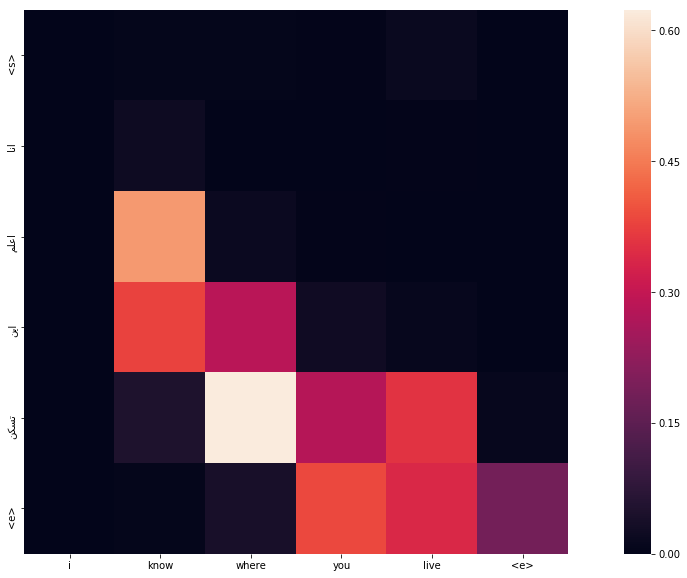

In [53]:
plt.figure(figsize=(20, 10))
sns.heatmap(df, square = True)

# References

1. https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention
2. https://medium.com/syncedreview/a-brief-overview-of-attention-mechanism-13c578ba9129